# Custom implementation of *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [1]:
import numpy as np
import pandas as pd
import itertools

from qiskit import Aer, transpile, QuantumRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit.library.data_preparation import StatePreparation

import warnings
warnings.filterwarnings("ignore")

### Utils

In [15]:
def Generate_matrix(replicate_paper, matrix_dimension, eig_values_list=None):
    """
    Synthetic matrix generator through input parameters: 
        -   replicate_paper: boolean parameter, recreate 2x2 matrix used in reference paper
        -   matrix_dimension: int parameter for synthetic matrix generation
        -   eig_values_list: optional eigenvalues list. if not provided, it will be calculated from generated matrix.
    Output :
        - synthetic matrix as numpy matrix.
        - normalization factor
    """

    if replicate_paper == False:
        # Generate hermitian matrix
        random_matrix=np.random.rand(matrix_dimension, matrix_dimension) 
        hermitian_matrix=np.dot(random_matrix, random_matrix.T)

        eig, e_v = np.linalg.eig(hermitian_matrix)
        if eig_values_list is None:
            eig_values_list = np.array(eig)
            print(eig_values_list)
        example_matrix = e_v @ np.diag(eig_values_list) @ e_v.T

    else:
        example_matrix = np.array([[1.5, 0.5],[0.5, 1.5]])
    
    norm_factor = np.trace(example_matrix)
    normalized_example_matrix = example_matrix/norm_factor

    print(f'Matrix:\n {example_matrix.round(2)}\n')
    for eigenval, eigenvec in zip(np.linalg.eig(example_matrix)[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])):
        print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')
    return normalized_example_matrix, norm_factor

In [3]:
def generate_qram_circuit(example_matrix):
    """
    For a generic matrix, the corrisponding qram circuit for matrix preprocessing into corrisponding quantum state. 

    Input parameters: 
        - example_matrix: generic matrix as numpy matrix.
    Output :
        - qc : preprocessing circuit.
    """

    flattened_matrix = example_matrix.flatten()
    norm = np.linalg.norm(flattened_matrix)
    state_preparation = StatePreparation(flattened_matrix / norm)

    num_qubits=int(np.ceil(np.log2(len(flattened_matrix))))
    qc = QuantumCircuit(num_qubits)

    qc.append(state_preparation, [i for i in range(num_qubits-1,-1,-1)])

    return qc

In [4]:
def phase_estimation(matrix, qram_circuit, resolution):
    """
    For a generic 2**n matrix, the corrisponding Quantum Phase Estimation for integer eigenvalues extraction 

    Input parameters: 
        - matrix: generic matrix as numpy matrix ( 2^N shape )
        - qram_circuit: preprocessing circuit
        - replicate_paper: boolean parameter, recreate 2x2 matrix used in reference paper
        - eigval_list: list of eigenvalues generated for testing purposes
    Output :
        - resolution: number of qubits used to represent the computed eigenvalues
        - pe : phase estimation circuit
    """

    #Unitary Operator for PE
    u_circuit = NumPyMatrix(matrix, evolution_time=2*np.pi)

    #PE circuit
    pe = PhaseEstimation(resolution, u_circuit, name = "PE")

    num_qubit = resolution+int(np.ceil(np.log2(len(matrix)**2)))

    pe_register = QuantumRegister(num_qubit, 'total')

    pe_circuit = QuantumCircuit(pe_register)

    pe_circuit.append(qram_circuit.to_gate(), pe_register[resolution:])
    pe_circuit.append(pe.to_gate(), pe_register[0:pe.num_qubits])

    return pe_circuit

def check_statevector(backend, pe_circuit, resolution, example_matrix):
    pe_job = backend.run(transpile(pe_circuit, backend=backend))
    statevector = np.asarray(pe_job.result().get_statevector()).round(3)

    bitstrings = [''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
    statevector_dict = {}
    for bitstring, amplitude in zip(bitstrings, statevector):
        statevector_dict[bitstring] = amplitude
    return statevector_dict

In [28]:
from scipy.signal import find_peaks

def eigen_estimation(probabilities, sign_dictionary, resolution, debug=False):
    """
    Estimate eigenvalues and eigenvectors from the input matrix and the relative output of state tomography 

    Input parameters: 
        - probabilities: the probabilities for each state obtained from tomography
        - sign dictionary: the signs of the reconstructed (via tomography) statevector
        - resolution: number of qubits used to represent the computed eigenvalues
    Output :
        - eigenvalues: eigenvalues of the input matrix
        - eigenvectors: eigenvectors of the input matrix
    """

    df = pd.DataFrame.from_dict(probabilities, orient='index')
    df.reset_index(inplace=True)
    df.columns=['state', 'module']

    df['lambda']=df['state'].apply(lambda x: x[-resolution:])
    df1=df.groupby('lambda').agg({'module':'sum'})
    #df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
    df1=df1.sort_values('module',ascending=False)
    df1.reset_index(inplace=True)
    df1['num']=df1['lambda'].apply(lambda x :int(x[::-1],base=2)/(2**resolution))

    peaks=[]
    nums_peaks=[]

    for i in find_peaks(df1.sort_values(['num'])['module'], threshold=0.001)[0]:
        el = df1.sort_values(['num']).iloc[i]
        nums_peaks.append(el['num'])
        peaks.append(el['lambda'])

    if debug == True:
        print(peaks, nums_peaks)
        df1[['num','module']].sort_values('num').set_index('num').plot(style='-*',figsize=(15,10))

    df.columns=['state','module','lambda']
    df['sign']=np.array(list(sign_dictionary.values()))
    df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
    df=df.fillna(0)

    a=[]
    save_sign=[]
    eigenvalues=[]
    for l in peaks:
        eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
        a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
        #print(a_)
        save_sign.append(np.sign(a_))
        #print(save_sign)
        
        a.append(np.sqrt(abs(a_)))

    #a=[a1,a2]

    for i in range(len(a)):
        # print(a[i])
        normalization_factor=np.sqrt((1/(sum(a[i]**2))))
        # print(normalization_factor)
        a[i]*=normalization_factor
        a[i]*=save_sign[i]
    
    print(a)
    len_eigenvector = len(list(probabilities.keys())[0])-resolution
    eigenvectors=[]
    for ll, eig in zip(a, eigenvalues):
        
        eigenvector=np.zeros(len_eigenvector) #put length of eigenvector
        save_sign=np.sign(ll)
        sv=abs(ll)
        max_list=[]
        scaled_statevectors=[]
        for e,i in enumerate(range(0,len(sv), len_eigenvector)):
            max_list.append(max(sv[i:i+len_eigenvector]))
            scaled_statevectors.append(sv[i:i+len_eigenvector]/max_list[e])
            #print(max_list,scaled_statevectors)
        idx_max=np.argmax(max_list)
        #print(idx_max)
        max_max=max_list[idx_max]
        #print(max_max)
        value=np.sqrt(max_max)
        #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
        eigenvector=scaled_statevectors[idx_max]*value*save_sign[len_eigenvector*idx_max:len_eigenvector*idx_max+len_eigenvector]
        eigenvectors.append((eig, eigenvector))

    return eigenvectors


In [29]:
def sign_estimation(pe_circuit, probabilities, n_shots):
    """
    Estimate signs for the circuit's statevector

    Input parameters: 
        - pe_circuit: circuit that performs phase estimation
        - probabilities: the probabilities for each state obtained from tomography
        - n_shots: number of shots
    Output :
        - sign_dictionary: dictionary containing the signs
    """

    # Create the first operator for tomography
    pe_circuit.remove_final_measurements()
    op_U = pe_circuit.to_gate(label='op_U').control()
    #Create the second operator for tomography
    op_V = StatePreparation(np.sqrt(list(probabilities.values())),label='c_V').control()

    qr_target = QuantumRegister(pe_circuit.num_qubits, 'target')
    qr_control = QuantumRegister(1, 'control_qubit')

    sign_estimation_circuit = QuantumCircuit(qr_target, qr_control, name='sign_estimation')
    sign_estimation_circuit.h(qr_control)
    sign_estimation_circuit.x(qr_control)

    sign_estimation_circuit.append(op_U, qr_control[:]+qr_target[:])
    sign_estimation_circuit.x(qr_control)
    sign_estimation_circuit.append(op_V, qr_control[:]+qr_target[:])
    sign_estimation_circuit.h(qr_control)
    sign_estimation_circuit.measure_all()

    backend_simulation = Aer.get_backend("qasm_simulator")
    job_for_sign = backend_simulation.run(transpile(sign_estimation_circuit, backend=backend_simulation), shots=n_shots)
    counts_for_sign = job_for_sign.result().get_counts()

    #Take only counts with control qubits equal to 0
    tmp=np.zeros(2**pe_circuit.num_qubits)
    for c in counts_for_sign:
        if c[0]=='0':
            tmp[int(c[1:],2)]=counts_for_sign[c]

    #Sign estimation
    sign_dictionary={}
    sign=0
    for e, (count, prob) in enumerate(zip(tmp, probabilities.values())):
        if count>0.4*prob*n_shots:
            sign=1
        else:
            sign=-1
        if prob==0:
            sign=1
        sign_dictionary.update({bin(e)[2:].zfill(pe_circuit.num_qubits):sign})
    
    return sign_dictionary

In [7]:
# Function constructed from the scipy pca class
def transform(original_matrix, eigenvalues, components):
    
    components = np.array(components)
    X_transformed = np.dot(original_matrix, components.T)
    X_transformed /= np.sqrt(eigenvalues)

    return X_transformed

## Main

#### Generate synthetic data

In [17]:
# Change this to False to generate a random matrix with choosen eigenvalues
replicate_paper = False
# Desired eigenvalues for the synthetic matrix
eigval_list = np.array([1, 4])
example_matrix, norm_factor = Generate_matrix(replicate_paper, matrix_dimension = 2)#, eig_values_list = eigval_list)

[1.69723927 0.18604055]
Matrix:
 [[1.49 0.52]
 [0.52 0.4 ]]

eigenvalue: 0 - eigenvector: [-0.372  0.928]
eigenvalue: 2 - eigenvector: [0.928 0.372]


as an example, we take the 2x2 matrix used in the original paper
$$
A_0=\left[\begin{array}{ll}
1.5 & 0.5 \\
0.5 & 1.5
\end{array}\right]
$$

whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

$20$ derives from $3^2 + 1^2 + 1^2 + 3^2$ and is necessary for normalization

#### Preprocessing 

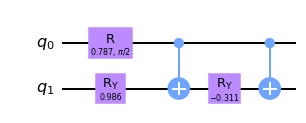

In [18]:
# Preprocessing circuit
matrix_circuit = generate_qram_circuit(example_matrix)
matrix_circuit.decompose(reps=4).draw("mpl")

In [19]:
#Check matrix encoding into quantum state
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'00': 0.759277269808268,
 '01': 0.093532393790006,
 '10': 0.093532393790006,
 '11': 0.053657942611719}

#### Phase Estimation

In [49]:
# Create and Add Phase estimation block to circuit
resolution = 8
pe_circuit = phase_estimation(example_matrix, matrix_circuit, resolution)

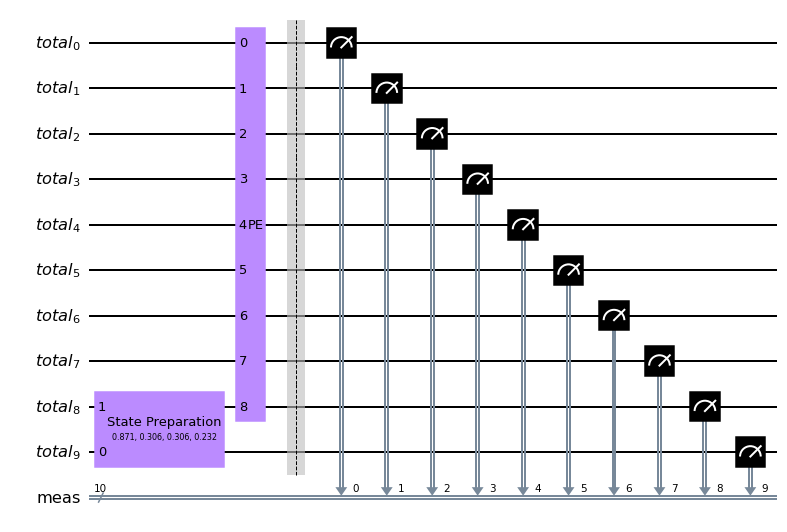

In [50]:
# Check that the circuit correctly estimates the eigenvalues 
# (only the states associated to the correct eigenvalues have probability amplitude different from 0)
# exact_statevector = check_statevector(backend,pe_circuit,resolution,example_matrix)
pe_circuit.measure_all()
# print(exact_statevector)
pe_circuit.decompose(reps=1).draw("mpl")

#### Quantum State Tomography

In [51]:
# Run the circuit using qiskit simulator

n_shots = 50000 # Increase to achieve higher accuracy
backend_simulation = Aer.get_backend("qasm_simulator")
job = backend_simulation.run(transpile(pe_circuit, backend=backend_simulation), shots=n_shots)
counts = job.result().get_counts()
# plot_histogram(counts)

In [52]:
# Reconstruct the probabilities of observing each state from the counts provided by the simulation, plus perform the sign tomography

probabilities = {}

for i in range(2**pe_circuit.num_qubits):
    binary_i = bin(i)[2:].zfill(pe_circuit.num_qubits)
    try:
        # Will approximate the modulus two of the values seen in exact_statevector, two cells above
        probabilities[binary_i] = counts[binary_i]/n_shots
    except KeyError:
        probabilities[binary_i] = 0.0

sign_dictionary = sign_estimation(pe_circuit, probabilities, n_shots)

#### Results

In [53]:
print("Quantum method results:")
result = eigen_estimation(probabilities, sign_dictionary, resolution, debug=False)
eigenvalues = []
eigenvectors = []
for eig, eigenvector in result:
    print(f'eigenvalue: {eig*norm_factor} - eigenvector: {np.real(eigenvector).round(3)}')
    eigenvalues.append(eig*norm_factor)
    eigenvectors.append(list(eigenvector))

Quantum method results:
[array([ 0.1880887 , -0.33995005, -0.34340141,  0.85506261]), array([0.86188628, 0.34358239, 0.34630034, 0.13848919])]
eigenvalue: 0.1839140456593473 - eigenvector: [-0.371  0.925]
eigenvalue: 1.699365781892369 - eigenvector: [0.928 0.37 ]


In [59]:
np.sqrt(0.87677821),np.sqrt(0.1880887),0.34340141/np.sqrt(0.87677821)

(0.9363643575019288, 0.4336919413593017, 0.3667390874596512)

In [48]:
np.sqrt(0.86218254),np.sqrt(0.14299745),.34531838/np.sqrt(0.86218254)

(0.9285378506016866, 0.37815003636123057, 0.371894780354119)

In [25]:
original_matrix = example_matrix*norm_factor
reduced_matrix = transform(original_matrix, eigenvalues, eigenvectors)
reduced_matrix.round(3)

array([[0.122, 1.205],
       [0.511, 0.483]])

Note: 

1) The signs of the eigenvectors are arbitrary. 
You can flip them without changing the meaning of ther result; only their direction matters.

2) One can improve the accuracy of the algorithm increasing the *resolution* parameter and the number of shots

In [26]:
print("Classically computed values:")
zipped_list = list(zip(np.linalg.eig(original_matrix)[0][::-1], np.rot90(np.linalg.eig(original_matrix)[1])))
cl_eigenvalues = []
cl_eigenvectors = []
for eigenval, eigenvec in sorted(zipped_list, key = lambda x: x[0]):
    print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')
    cl_eigenvalues.append(eigenval)
    cl_eigenvectors.append(list(eigenvec))

Classically computed values:
eigenvalue: 0 - eigenvector: [-0.372  0.928]
eigenvalue: 2 - eigenvector: [0.928 0.372]


In [27]:
classically_reduced_matrix = transform(original_matrix, cl_eigenvalues, cl_eigenvectors)
classically_reduced_matrix.round(3)

array([[-0.161,  1.209],
       [ 0.4  ,  0.485]])